# Imports


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import correlate
from keras import Model
from keras.layers import Conv1D, Input, MaxPooling1D, UpSampling1D, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from scipy.stats import kurtosis
import time
from sklearn import preprocessing as pp
print("Imported")

Imported


In [3]:
from google.colab import drive
drive.mount('/content/drive')
print("mounted")


Mounted at /content/drive
mounted


# Load Data and Compute functions

In [4]:
x_train = np.load('/content/drive/MyDrive/ml_project/xtrainnewv7.npy').astype(np.float32) * 10
y_train = np.load('/content/drive/MyDrive/ml_project/ytrainnewv7.npy')
x_test = np.load('/content/drive/MyDrive/ml_project/xtestnewv7.npy').astype(np.float32) * 10
y_test = np.load('/content/drive/MyDrive/ml_project/ytestnewv7.npy')

In [5]:
#HERE VOLTS mean CURRENT - TYPO
def get_noise_for_phase(x_volts, target_snr_db):
    x_watts = x_volts ** 2
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    noise_volts = x_volts + noise_volts
    return noise_volts

# def differentiate_noisy_data(noise_ad):
#     new_data=[]
#     for j in noise_ad:
#         df = pd.DataFrame(j).diff().diff()
#         x = df.iloc[2:,:].values
#         new_data.append(x)
#     return np.array(new_data)


# Noise FN
def noisef(snr, X_Train, X_Test):  
    noise_ar=[]
    for i in X_Train:
        #A
        xcA = i[:,3:4].flatten()
        noise_currentA = get_noise_for_phase(xcA, snr)
        #B
        xcB = i[:,4:5].flatten()
        noise_currentB = get_noise_for_phase(xcB, snr)
        #C
        xcC = i[:,5:6].flatten()  
        noise_currentC = get_noise_for_phase(xcC, snr)

        xvA = i[:,0:1].flatten()
        noise_voltA = get_noise_for_phase(xvA, snr)
        #B
        xvB = i[:,1:2].flatten()
        noise_voltB = get_noise_for_phase(xvB, snr)
        #C
        xvC = i[:,2:3].flatten()  
        noise_voltC = get_noise_for_phase(xvC, snr)
        
        #noise_tr = np.concatenate((i[:,0:3], noise_currentA.reshape(-1,1),noise_currentB.reshape(-1,1),noise_currentC.reshape(-1,1)),axis=1)
        #noise_tr = np.concatenate((noise_voltA.reshape(-1,1),noise_voltB.reshape(-1,1),noise_voltC.reshape(-1,1),i[:,3:6] ),axis=1)
        noise_tr = np.concatenate((noise_voltA.reshape(-1,1),noise_voltB.reshape(-1,1),noise_voltC.reshape(-1,1), noise_currentA.reshape(-1,1),noise_currentB.reshape(-1,1),noise_currentC.reshape(-1,1)),axis=1)

        noise_ar.append(noise_tr)
        
    noise_ad = np.array(noise_ar)
    #difference train data
    new_xtrain = noise_ad #differentiate_noisy_data(noise_ad)

    noise_ar=[]
    for i in X_Test:
        #A
        xcA = i[:,3:4].flatten()
        noise_currentA = get_noise_for_phase(xcA, snr)
        #B
        xcB = i[:,4:5].flatten()
        noise_currentB = get_noise_for_phase(xcB, snr)
        #C
        xcC = i[:,5:6].flatten()  
        noise_currentC = get_noise_for_phase(xcC, snr)

        xvA = i[:,0:1].flatten()
        noise_voltA = get_noise_for_phase(xvA, snr)
        #B
        xvB = i[:,1:2].flatten()
        noise_voltB = get_noise_for_phase(xvB, snr)
        #C
        xvC = i[:,2:3].flatten()  
        noise_voltC = get_noise_for_phase(xvC, snr)
        
        #noise_tr = np.concatenate((i[:,0:3], noise_currentA.reshape(-1,1),noise_currentB.reshape(-1,1),noise_currentC.reshape(-1,1)),axis=1)
        #noise_tr = np.concatenate((noise_voltA.reshape(-1,1),noise_voltB.reshape(-1,1),noise_voltC.reshape(-1,1),i[:,3:6] ),axis=1)
        noise_tr = np.concatenate((noise_voltA.reshape(-1,1),noise_voltB.reshape(-1,1),noise_voltC.reshape(-1,1), noise_currentA.reshape(-1,1),noise_currentB.reshape(-1,1),noise_currentC.reshape(-1,1)),axis=1)

        noise_ar.append(noise_tr)
        
    noise_ad = np.array(noise_ar)
    # difference test data
    new_xtest = noise_ad # differentiate_noisy_data(noise_ad)
    return new_xtrain, new_xtest
print("done")


done


In [6]:
def windowing(x_train,y_train,x_test,y_test, stride=168):
    X_Train=[]
    Y_Train=[]
    for i in range(0,len(x_train)-stride,stride):
        X_Train.append(x_train[i])
        Y_Train.append(y_train[i])
    X_Train = np.array(X_Train)
    Y_Train = np.array(Y_Train)
    print(X_Train.shape)
    X_Test=[]
    Y_Test=[]
    for i in range(0,len(x_test)-stride,stride):
        X_Test.append(x_test[i])
        Y_Test.append(y_test[i])
    X_Test = np.array(X_Test)
    Y_Test = np.array(Y_Test)
    return X_Train, Y_Train, X_Test, Y_Test

#X_Train, Y_Train, X_Test, Y_Test = windowing(x_train,y_train,x_test,y_test)

def windowing1(X, time_steps=166):
    Xs, ys = [], []
    for i in range(0,len(X) - time_steps, time_steps):
        v = X[i:(i + time_steps),:]
        Xs.append(v)
       #Xs.append(X[i])
    Xs=np.array(Xs)
    return Xs

# Model

In [7]:
def create_model():
    #Model
    input_window = Input(shape=(168,3))
    x = Conv1D(8, 3, padding="same", kernel_initializer='uniform')(input_window) 
    x = BatchNormalization()(x)
    x = LeakyReLU(0.03)(x)
    # x = ReLU()(x)
    x = MaxPooling1D(2, padding="same")(x) 
    x = Conv1D(4, 3, padding="same", kernel_initializer='uniform')(x) 
    x = BatchNormalization()(x)
    x = LeakyReLU(0.03)(x)
    # x = ReLU()(x)
    encoded = MaxPooling1D(2, padding="same")(x)
    encoder = Model(input_window, encoded)

    x = Conv1D(4, 3, padding="same", kernel_initializer='uniform')(encoded) 
    x = LeakyReLU(0.03)(x)
    # x = ReLU()(x)
    x = UpSampling1D(2)(x) 
    x = Conv1D(8, 3,padding="same", kernel_initializer='uniform')(x) 
    x = LeakyReLU(0.03)(x)
    # x = ReLU()(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(3, 3, padding='same', kernel_initializer='uniform')(x) 
    decoded = LeakyReLU(0.03)(decoded)
    # decoded = ReLU()(decoded)
    autoencoder = Model(input_window, decoded)
    return autoencoder

autoencoder = create_model()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 168, 8)            80        
_________________________________________________________________
batch_normalization (BatchNo (None, 168, 8)            32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 168, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 84, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 84, 4)             100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 4)             16  

# Correlation Function

In [16]:
threshold = 0
def calculate_correlation(data):
    #correlate works on 1D array; therefore calculate correte seperately for every features and add.
    #voltages are more important features because it has more oscillation
    pred = autoencoder.predict(data)
    corr = []
    for i in range(len(pred)):
        cl = correlate(data[i][:,:].flatten(), pred[i][:,:].flatten())
        corr.append(cl[0])

    sns.distplot(corr)
    plt.show()
    # threshold for faults
    #threshold = np.floor(np.min(corr))
    global threshold
    threshold = np.min(corr)
    #threshold = np.floor(np.max(corr))
    print(f"Corr Train threshold:{threshold}, max: {np.max(corr)}")


# Data Preprocessing

(1098, 168, 6)
RawData x_train: (184590, 168, 6), y_train: (184590, 6), x_test: (91867, 168, 6), y_test: (91867, 6)
Training Data X: (2196, 168, 3) Y: (2196, 6)
Test Data X: (546, 168, 3) , Y: (546, 6)


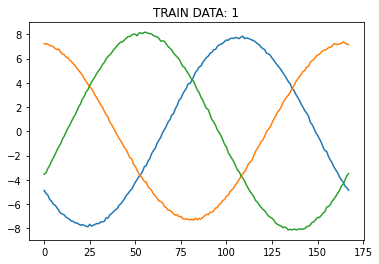

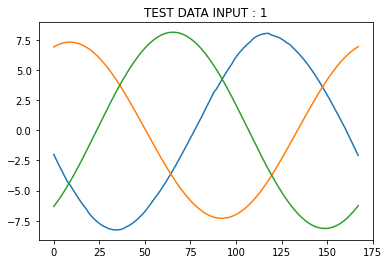

In [9]:
#######################################################################################################################
#Windowing
X_Train, Y_Train, X_Test, Y_Test = windowing(x_train, y_train, x_test, y_test)

#######################################################################################################################
#NOISE
X_Train_TT, X_Test_TT = noisef(40, X_Train, X_Test)
X_Train_Merged = []
Y_Train_Merged = []
for i in range(len(X_Train)):
    X_Train_Merged.append(X_Train[i])
    X_Train_Merged.append(X_Train_TT[i])
    Y_Train_Merged.append(Y_Train[i])
    Y_Train_Merged.append(Y_Train[i])
X_Train, Y_Train = np.array(X_Train_Merged), np.array(Y_Train_Merged)


####USING ONLY CURRENT####
X_Train = X_Train[:, :, 3:6]
X_Test = X_Test[:, :, 3:6]



#######################################################################################################################
print(f"RawData x_train: {x_train.shape}, y_train: {y_train.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}")
print(f"Training Data X: {X_Train.shape} Y: {Y_Train.shape}")
print(f"Test Data X: {X_Test.shape} , Y: {Y_Test.shape}")



#######################################################################################################################
x_test_plot = 112
x_train_plot = 51

plt.plot(X_Train[x_train_plot][0:168])
plt.title(f"TRAIN DATA: {Y_Train[x_train_plot][0]}")
plt.show()
plt.plot(X_Test[x_train_plot][0:168])
plt.title(f"TEST DATA INPUT : {Y_Test[x_train_plot][0]}")
plt.show()

# Train Model

In [13]:
#np.random.seed(0)
autoencoder = create_model()
epochs = 70
learning_rate = 0.005
batch_size = 10
autoencoder.compile(optimizer=Adam(learning_rate= learning_rate), loss='mse')
history = autoencoder.fit(X_Train, X_Train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_split=0.25,
                          shuffle=True)

Epoch 1/70
165/165 [==============================] - 22s 15ms/step - loss: 24.3080 - val_loss: 19.3049
Epoch 2/70
165/165 [==============================] - 1s 7ms/step - loss: 7.1891 - val_loss: 6.8290
Epoch 3/70
165/165 [==============================] - 1s 7ms/step - loss: 5.3246 - val_loss: 5.0869
Epoch 4/70
165/165 [==============================] - 1s 7ms/step - loss: 5.0457 - val_loss: 6.4286
Epoch 5/70
165/165 [==============================] - 1s 7ms/step - loss: 2.5746 - val_loss: 0.9580
Epoch 6/70
165/165 [==============================] - 1s 7ms/step - loss: 0.3378 - val_loss: 0.3636
Epoch 7/70
165/165 [==============================] - 1s 7ms/step - loss: 0.2556 - val_loss: 0.3098
Epoch 8/70
165/165 [==============================] - 1s 7ms/step - loss: 0.2100 - val_loss: 0.4774
Epoch 9/70
165/165 [==============================] - 1s 7ms/step - loss: 0.1792 - val_loss: 1.0997
Epoch 10/70
165/165 [==============================] - 1s 7ms/step - loss: 0.1564 - val_loss: 0.

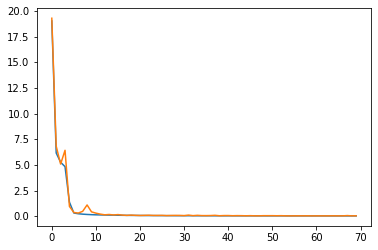

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


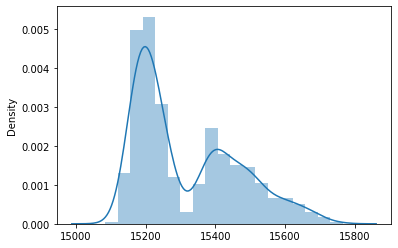

Corr Train threshold:15083.75432821446, max: 15766.593013635342


In [18]:
calculate_correlation(X_Train)

# Test Model Functions

In [19]:
def test_model(x_test, y_test):
    tspreds = autoencoder.predict(x_test)
    testcor = []
    for i in range(len(tspreds)):
        cl = correlate(x_test[i][:,:].flatten(), tspreds[i][:,:].flatten())
        testcor.append(cl[0])
        
    print(f"Corr Threshold : {threshold}")
    sns.distplot(testcor)
    plt.show()
    #print(f"Test Corr Min {np.min(testcor)}, Max: {np.max(testcor)}")
    
    df = pd.DataFrame(y_test, columns=['ytrue', 'id', 'phaseA', 'phaseB', 'phaseC', 'nofault'])
    #print(f"{df.head()}")
    # df['corr'] = testcor
    thresh = threshold
    ypred = [1 if a >= thresh else 0 for a in testcor]
    from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
    cf = confusion_matrix(y_true = df.iloc[:, 0:1], y_pred= ypred, labels = [0,1])
    TN, FP, FN, TP = cf[0][0], cf[0][1], cf[1][0], cf[1][1]
    Dependability = TP / (TP + FP)
    Security = TN / (TN + FN)
    Safety = TN / (TN + FP)
    Sensibility = TP / (TP + FN)
    print('confusion matrix \n', cf)
    print('accuracy:', np.round(accuracy_score(df.iloc[:, 0:1], ypred), 4) * 100)
    print('Security', np.round(Security, 4) * 100)
    print('Dependability:', np.round(Dependability, 4) * 100)
    print('Safety', np.round(Safety, 4) * 100)
    print('Sensibility', np.round(Sensibility, 4) * 100)

def timer_threshold_test(x_test_t, y_test_t):
    tspreds = autoencoder.predict(x_test_t)
    testcor = []
    for i in range(len(tspreds)):
        cl = correlate(x_test_t[i][:,:].flatten(), tspreds[i][:,:].flatten())
        testcor.append(cl[0])
    
    #test_thresh = np.min(testcor)
    #print(f"Timer Test Corr thresh {test_thresh}")
    
    df=pd.DataFrame(y_test_t, columns=['ytrue','id','phaseA','phaseB','phaseC', 'nofault'])
    df['corr'] = testcor
    thresh=threshold
    ypred=[1 if a>=thresh else 0 for a in testcor]
    df['ypred'] = ypred
    from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
    cf = confusion_matrix(y_true = df.iloc[:, 0:1], y_pred= df['ypred'], labels = [0,1])
    TN,FP,FN,TP=cf[0][0], cf[0][1], cf[1][0], cf[1][1]
    Dependability = TP/(TP+FP)
    Security = TN/(TN+FN)
    Safety = TN/(TN+FP)
    Sensibility = TP/(TP+FN)

    FPsv = df[((df['ypred']==1) & (df['ytrue']==0))]
    FNsv = df[((df['ypred']==0) & (df['ytrue']==1))]
    TPsv = df[((df['ypred']==1) & (df['ytrue']==1))]
    TNsv = df[((df['ypred']==0) & (df['ytrue']==0))]

    arr=np.array(FPsv.index)

    new_arr=[]
    for i in range(len(arr)-2):
        if arr[i] == arr[i+1]-1 and arr[i] == arr[i+2]-2:
            new_arr.append(arr[i])

    ids= np.setdiff1d(arr,new_arr)

    FPCount= len(ids)

    df=df.drop(ids)

    from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
    cf = confusion_matrix(y_true = df.iloc[:, 0:1], y_pred= df['ypred'], labels = [0,1])
    TN,FP,FN,TP=cf[0][0], cf[0][1], cf[1][0], cf[1][1]
    Dependability = TP/(TP+FP)
    Security = TN/(TN+FN)
    Safety = TN/(TN+FP)
    Sensibility = TP/(TP+FN)

    arr=np.array(FNsv.index)
    #print(f"FN : {len(arr)}")
    new_arr=[]
    for i in range(len(arr)-2):
        if arr[i] == arr[i+1]-1 and arr[i] == arr[i+2]-2:
            new_arr.append(arr[i])

    ids=np.setdiff1d(arr,new_arr)

    FNCount= len(ids)
    df=df.drop(ids)    
    
    from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, auc
    cf = confusion_matrix(y_true = df.iloc[:, 0:1], y_pred= df['ypred'], labels = [0,1])
    TN,FP,FN,TP=cf[0][0], cf[0][1], cf[1][0], cf[1][1]
    Dependability = TP/(TP+FP)
    Security = TN/(TN+FN)
    Safety = TN/(TN+FP)
    Sensibility = TP/(TP+FN)
    
    TP_Timer = TP + FNCount
    TN_Timer = TN + FPCount
    
    accuracy = np.round((TP_Timer+TN_Timer)/(TP_Timer+TN_Timer+FP+FN),4)*100
    print('confusion matrix \n', cf )
    print('Non window accuracy:', np.round(accuracy_score(df.iloc[:,0:1],df['ypred'].values),4)*100)
    print('accuracy:', accuracy)
    print('Security',np.round(Security,4)*100)
    print('Dependability:',np.round(Dependability,4)*100)
    print('Safety',np.round(Safety,4)*100)
    print('Sensibility', np.round(Sensibility,4)*100)
    #print(f"TEST: {TP}, {TN}, {FP} , {FN}, FPCount: {FPCount} , FNCount: {FNCount} ACC: {accuracy}")
    return tspreds, testcor


In [20]:
def test_with_noisy_data(snr=30, set_seed = True):
  if(set_seed):
    #SEED
    np.random.seed(0)

  #LOAD DATA
  X_Train, Y_Train, X_Test, Y_Test = windowing(x_train, y_train, x_test, y_test)

  #NOISING
  X_Train_N, X_Test_N = noisef(snr, X_Train, X_Test)

  print(f"Noisy Test Data : X_Test : {X_Test_N.shape} ,Y_Test: {Y_Test.shape}")

  X_Test_N = X_Test_N[:,:,3:6]
  ###TESTB
  test_model(X_Test_N, Y_Test)
  timer_threshold_test(X_Test_N, Y_Test)

# Test Model

Corr Threshold : 15083.75432821446


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


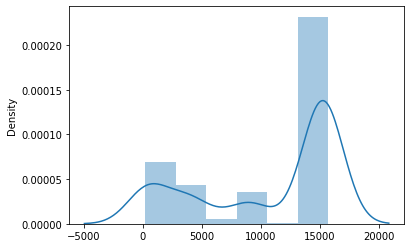

confusion matrix 
 [[267   5]
 [  0 274]]
accuracy: 99.08
Security 100.0
Dependability: 98.21
Safety 98.16
Sensibility 100.0
confusion matrix 
 [[267   0]
 [  0 274]]
Non window accuracy: 100.0
accuracy: 100.0
Security 100.0
Dependability: 100.0
Safety 100.0
Sensibility 100.0


In [22]:
test_model(X_Test, Y_Test)
pred, t_cor = timer_threshold_test(X_Test, Y_Test)

(1098, 168, 6)
Noisy Test Data : X_Test : (546, 168, 6) ,Y_Test: (546, 6)
Corr Threshold : 15083.75432821446


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


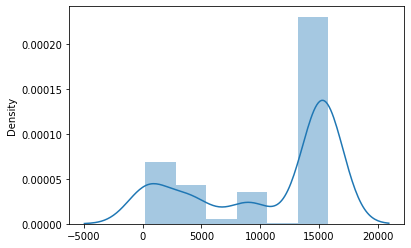

confusion matrix 
 [[262  10]
 [  1 273]]
accuracy: 97.99
Security 99.62
Dependability: 96.47
Safety 96.32
Sensibility 99.64
confusion matrix 
 [[262   0]
 [  0 273]]
Non window accuracy: 100.0
accuracy: 100.0
Security 100.0
Dependability: 100.0
Safety 100.0
Sensibility 100.0


In [23]:
test_with_noisy_data(snr = 30)

# INRUSH

inrush: (19999, 6) inrushx : (119, 168, 6), inrushy : (119, 6)
Corr Threshold : 15083.75432821446


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


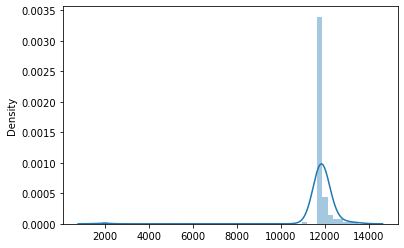

confusion matrix 
 [[119   0]
 [  0   0]]
accuracy: 100.0
Security 100.0
Dependability: nan
Safety 100.0
Sensibility nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


In [33]:
#INRSUH
#Data load
inrush=np.load('/content/drive/MyDrive/ml_project/inrushPlot.npy').astype(np.float32)*10

#Windowing
inrushx = windowing1(inrush, 168)
inrushy = np.zeros((inrushx.shape[0],6))

print(f"inrush: {inrush.shape} inrushx : {inrushx.shape}, inrushy : {inrushy.shape}")

#TEST
test_model(inrushx[:,:, 3:6], inrushy)

# Remote HIF

Corr Threshold : 15083.75432821446


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


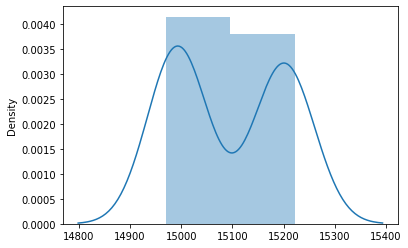

confusion matrix 
 [[12  0]
 [ 0 11]]
accuracy: 100.0
Security 100.0
Dependability: 100.0
Safety 100.0
Sensibility 100.0


In [25]:
#REMOTE HIF
#Load Data
remote_hif_x = np.load('/content/drive/MyDrive/ml_project/remote_hif.npy').astype(np.float32)*10
remote_hif_y = np.zeros((remote_hif_x.shape[0],6))
remote_hif_y[2000:,:] = 1

#Windowing
remote_hif_x = windowing1(remote_hif_x, 168)
remote_hif_y = windowing1(remote_hif_y, 168)
remote_hif_y = remote_hif_y[:,0,:]


#print(f" Remote HIF X : {remote_hif_x.shape}, Y : {remote_hif_y.shape}")

#TEST
test_model(remote_hif_x[:,:,3:6], remote_hif_y)


# Non Linear


 non_lin_x : (148, 168, 6), non_lin_y : (148, 6)
Corr Threshold : 15083.75432821446


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


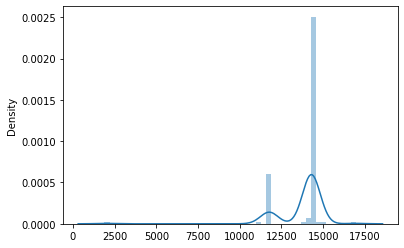

confusion matrix 
 [[146   2]
 [  0   0]]
accuracy: 98.65
Security 100.0
Dependability: 0.0
Safety 98.65
Sensibility nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


In [37]:
#Non linear
#Data load
non_lin_x = np.load('/content/drive/MyDrive/ml_project/nonLinv2.npy').astype(np.float32)*10

#Windowing
non_lin_x = windowing1(non_lin_x, 168)
non_lin_y = np.zeros((non_lin_x.shape[0],6))

print(f" non_lin_x : {non_lin_x.shape}, non_lin_y : {non_lin_y.shape}")

#TEST
test_model(non_lin_x[:,:, 3:6], non_lin_y)


# Prediction plots

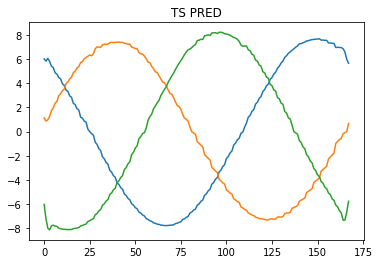

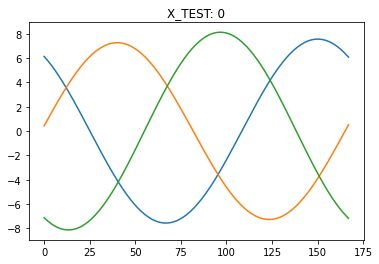

Threshold: 15083.75432821446
Corr: 14994.0634765625
---------------------------------------------------------------


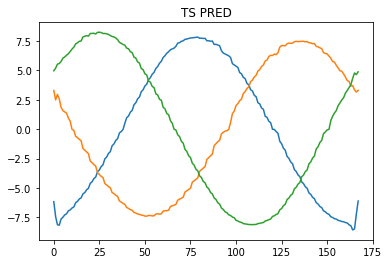

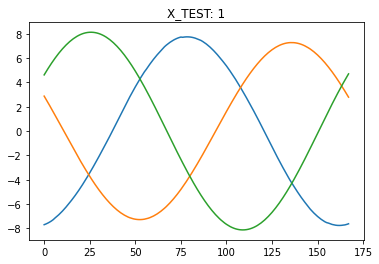

Threshold: 15083.75432821446
Corr: 15248.54296875


In [38]:
instance = 100
plt.plot(pred[instance])
plt.title(f"TS PRED")
plt.show()
plt.plot(X_Test[instance])
plt.title(f"X_TEST: {Y_Test[instance][0]}")
plt.show()
print(f"Threshold: {threshold}")
print(f"Corr: {t_cor[instance]}")
print("---------------------------------------------------------------")
instance = 0
plt.plot(pred[instance])
plt.title(f"TS PRED")
plt.show()
plt.plot(X_Test[instance])
plt.title(f"X_TEST: {Y_Test[instance][0]}")
plt.show()
print(f"Threshold: {threshold}")
print(f"Corr: {t_cor[instance]}")
